# Cats-vs.-Dogs Image Classification. CNNs: Transfer Learning

As discussed in earlier sections, the high feature-to-sample ratio in the cats and dogs dataset poses challenges for classification accuracy, increasing the risk of overfitting in both traditional machine learning models and convolutional neural networks (CNNs). Unlike traditional models, which require dimensionality reduction techniques like PCA or HOG, CNNs can process image data directly.

This notebook showcases the power of transfer learning with CNNs for cat/dog classification, achieving an accuracy above 0.95. Using a preprocessed dataset of 2,000 color images (150x150 pixels, with cats labeled $y=0$ and dogs $y=1$), the final layers of the Inception V3 model are tuned, leveraging its pre-trained features to enhance performance on this dataset. To accelerate training and optimize computational efficiency, it is recommended to use a GPU environment in Google Colab, which significantly reduces computation times for the resource-intensive CNN training process.

- **Dataset Reference**: Sachin, Shaunthesheep (2020). Dataset: Cats-vs-Dogs : image dataset for binary classification. URL: [https://www.kaggle.com/shaunthesheep/microsoft-catsvsdogs-dataset](https://www.kaggle.com/shaunthesheep/microsoft-catsvsdogs-dataset)

## Setup: Importing Packages and Defining Utility Functions
The following cells import the required packages and defines functions to enhance code readability and prevent duplication.

In [ ]:
# General imports
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import requests
import zipfile
import io
import seaborn as sns
import requests
import cv2
from math import ceil
from io import BytesIO
from itertools import product

# Scikit-learn: machine learning library
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Tensorflow and Keras: neural network framework
from tensorflow import reduce_prod
from tensorflow.config.experimental import enable_op_determinism
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import set_random_seed
from keras.optimizers import RMSprop
from keras.layers import InputLayer, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Model
from keras.applications import InceptionV3
from tensorflow.image import resize

In [ ]:
# Global variables
BASE_URL = "https://raw.githubusercontent.com/alexARC26/portfolio-classification-neural-networks/main/data/"
DATASET_URL_1 = BASE_URL + "CatsDogsDataset_1.zip"
DATASET_URL_2 = BASE_URL + "CatsDogsDataset_2.zip"
CSV_FILENAME = "CatsDogsDataset.csv"
IMAGE_SIZE = 150
CLASS_NAMES = ["Cat", "Dog"]

# Data input functions
def read_csv_from_github_zip(zip_url, csv_filename):
    """
    Download a ZIP file from a GitHub URL, extract a specified CSV, and return it as a DataFrame.

    Parameters:
        zip_url (str): URL of the ZIP file hosted on GitHub.
        csv_filename (str): Name of the CSV file to extract from the ZIP.

    Returns:
        pd.DataFrame: DataFrame containing the CSV data, or None if an error occurs.
    """
    try:
        # Download the ZIP file from the provided URL. Raise an exception for HTTP errors (e.g., 404)
        response = requests.get(zip_url)
        response.raise_for_status()

        # Create a file-like object from the downloaded ZIP content
        zip_content = io.BytesIO(response.content)

        # Open the ZIP file for reading
        with zipfile.ZipFile(zip_content, 'r') as zf:
            # Check if the specified CSV exists in the ZIP
            if csv_filename not in zf.namelist():
                raise ValueError(f"CSV file '{csv_filename}' not found in ZIP")

            # Extract and read the CSV file directly into a DataFrame
            with zf.open(csv_filename) as csv_file:
                df = pd.read_csv(csv_file)

        # Return the resulting DataFrame
        return df

    except requests.exceptions.RequestException as e:
        # Handle network or HTTP errors during download
        print(f"Error downloading ZIP from {zip_url}: {e}")
        return None

    except zipfile.BadZipFile:
        # Handle cases where the downloaded file is not a valid ZIP
        print(f"Error: The file at {zip_url} is not a valid ZIP")
        return None

    except Exception as e:
        # Catch any other errors (e.g., CSV parsing issues, file corruption)
        print(f"Error processing ZIP or CSV: {e}")
        return None

# Plot image functions
def plot_single_image(X_values, subtitle_text="", colorMap=None, yText=None):
    """
    Plot a single image with optional subtitle and text label.

    Parameters:
      X_values: Array-like, image data (1D or 3D format).
      subtitle_text: String, title for the image (default: "").
      colorMap: String, matplotlib colormap for the image (default: None).
      yText: String, text to display on the y-axis (default: None).

    Returns:
      None: a Matplotlib plot of the image.
    """
    # Check if X_values is in 1D format and reshape to 3D if necessary
    dim_X = len(X_values.shape)
    if dim_X == 1:
        n_color_channels = int(X_values.shape[0] / (IMAGE_SIZE * IMAGE_SIZE))

        # Reshape 1D array to 3D (height, width, channels) and normalize pixel values
        X_values = np.array(X_values).reshape(IMAGE_SIZE, IMAGE_SIZE, n_color_channels)
        X_values = X_values / 255

        # Set colormap to grayscale for single-channel images
        colorMap = "gray"

    # Display the image, add subtitle and hide axes for tidier visualization
    plt.imshow(X_values, interpolation='nearest', cmap=colorMap)
    plt.title(subtitle_text, fontsize=14, loc="left")
    plt.axis('off')

    # Add optional text label on the y-axis
    if yText is not None:
        plt.text(x=-0.2, y=0.5, s=yText, ha='center', va='center',
                 transform=plt.gca().transAxes, fontsize=14)

def plot_gallery(X_values, y_values, y_labels=None, selection=None, main_title="Image Gallery", title_offset=[0.075, 0.97]):
    """
    Plot a gallery of images with their class labels and optional predicted labels.

    Parameters:
      X_values: Array-like or DataFrame, image data.
      y_values: Array-like, true class labels for the images.
      y_labels: Array-like, predicted class labels (default: None).
      selection: List, indices of images to display (default: None, uses all images).
      main_title: String, title for the gallery (default: "Image Gallery").
      title_offset: List, [x, y] coordinates for the main title (default: [0.075, 0.97]).

    Returns:
      None: a Matplotlib gallery of images.
    """
    # Use all images if no selection is provided
    if selection is None:
        selection = list(range(len(y_values)))

    # Initialize figure with specified size. Also, set # of images to display in n_rows
    fig = plt.figure(figsize=(17, 10))
    n_in_gallery = 15
    n_rows = 3

    # Select a random subset of images from the selection
    n_in_selection = len(selection)
    random_subset = random.sample(sorted(selection), min(n_in_gallery, n_in_selection))

    # Plot each image in the gallery
    for i in range(min(n_in_gallery, n_in_selection)):
        plt.subplot(n_rows, int(np.ceil(n_in_gallery / n_rows)), i + 1)
        random_index = random_subset[i]

        # Extract single image data (handle DataFrame or array input)
        if isinstance(X_values, pd.DataFrame):
            single_row = X_values.iloc[random_index, ]
        else:
            single_row = X_values[random_index, ]

        # Create subtitle with true class name and optional predicted label
        subtitle_text = CLASS_NAMES[y_values[random_index]]
        if y_labels is not None:
            subtitle_text += ". Pred: " + CLASS_NAMES[y_labels[random_index]]

        plot_single_image(X_values=single_row, subtitle_text=subtitle_text)

    # Adjust layout and add main title
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle(main_title, x=title_offset[0], y=title_offset[1], fontsize=16)
    plt.show()

# Data Load
The following cell loads the dataset as a DataFrame, pre-processesed as done within from the `Preprocessing` notebook in the `utils` folder (specifically, it uses the first 2,000 images -forming the dataset rows-, resized to 150x150 pixels). Moreover, it divides the variables into the pixels' RGB values (`complete_X`) and reponse variable (`complete_y`).

In [ ]:
print("Reading datafiles the ZIP files from Github...")
cats_dogs_df_part_1 = read_csv_from_github_zip(DATASET_URL_1, CSV_FILENAME)
cats_dogs_df_part_2 = read_csv_from_github_zip(DATASET_URL_2, CSV_FILENAME)

if cats_dogs_df_part_1 is not None and cats_dogs_df_part_2 is not None:
  # Both datasets are concatenated
  cats_dogs_df = pd.concat([cats_dogs_df_part_1, cats_dogs_df_part_2]).reset_index(drop=True)

  # Data split into features and dependent variable
  complete_X = cats_dogs_df.iloc[:,:-1]
  complete_y = cats_dogs_df["Class"].astype(int)
  print("Data loaded successfully.")
else:
  print("Failed to load data from GitHub.")

Reading datafiles the ZIP files from Github...
Data loaded successfully.


Data can either be visualized as a matrix of RGB values or as images. Moreover, `complete_X` is given a four-dimensional shape (number of images, width, height, color channels) and unused variables are deleted with `del` to save memory efficiently.

In [ ]:
cats_dogs_df.head()

,R_1_1,G_1_1,B_1_1,R_1_2,G_1_2,B_1_2,R_1_3,G_1_3,B_1_3,R_1_4,...,R_150_148,G_150_148,B_150_148,R_150_149,G_150_149,B_150_149,R_150_150,G_150_150,B_150_150,Class
0,203,164,87,208,169,92,210,171,94,212,...,1,1,0,1,1,0,1,1,0,0
1,37,42,38,38,42,41,38,42,45,37,...,46,32,23,61,48,39,39,26,17,0
2,28,33,39,12,16,25,22,26,38,38,...,195,194,5,184,181,8,172,167,5,0
3,223,224,219,223,224,219,223,224,219,222,...,212,211,209,215,212,207,216,212,209,0
4,134,110,66,135,111,67,139,117,70,145,...,104,92,66,91,81,56,90,80,55,0


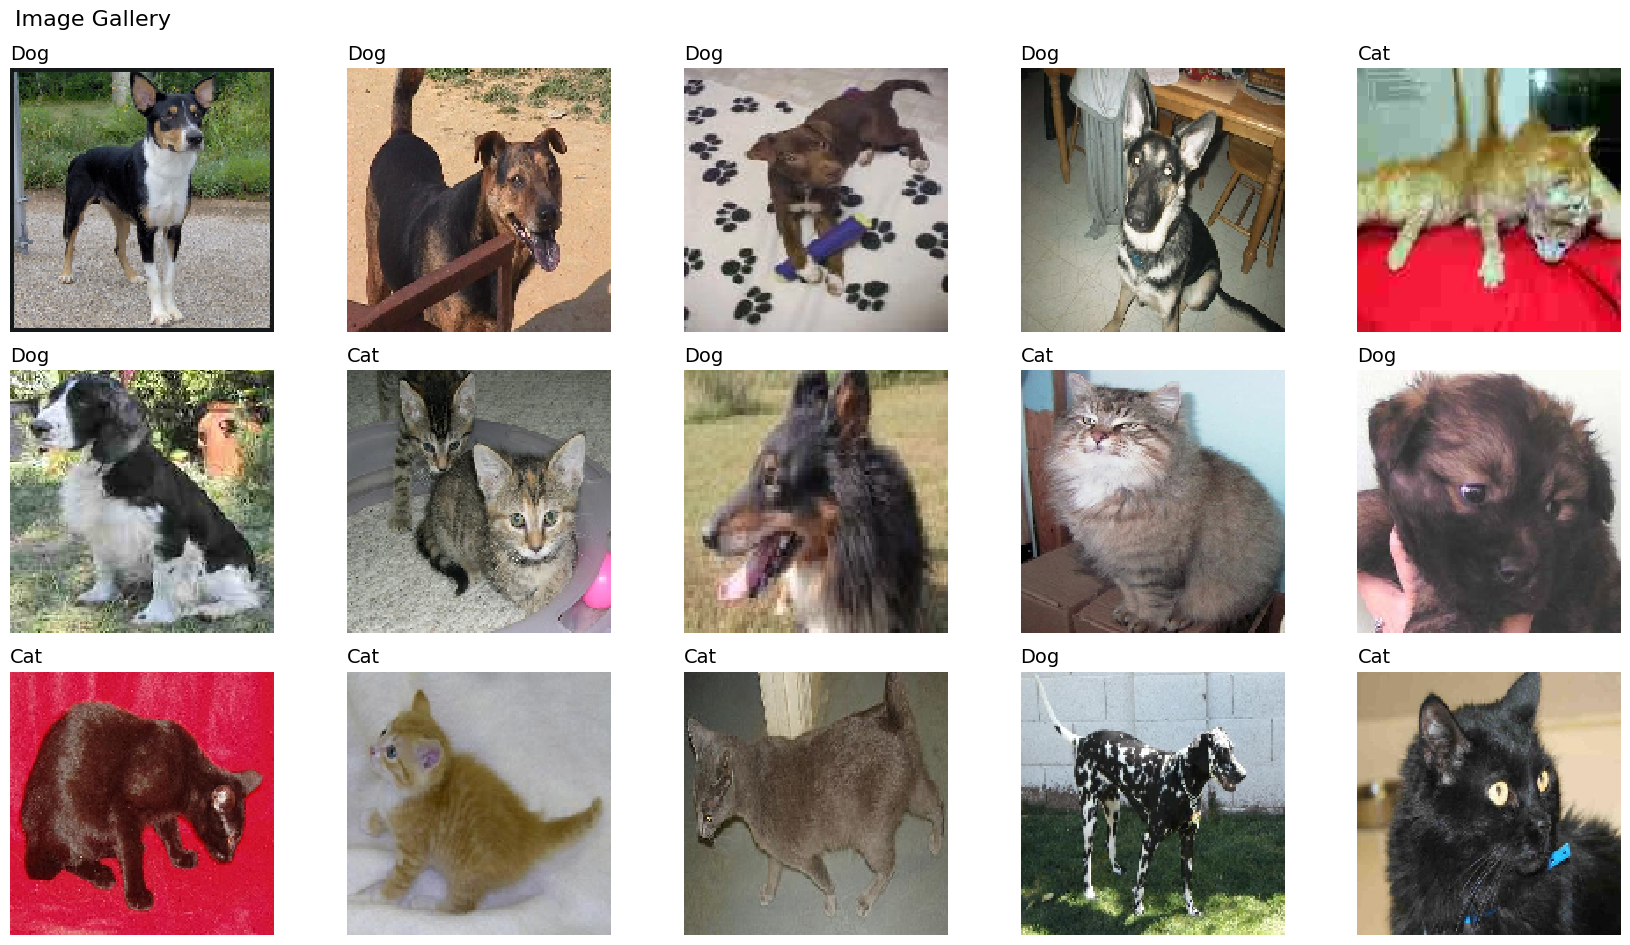

In [ ]:
# Plot gallery of images
plot_gallery(complete_X, complete_y)

# Features to 3D format and normalization
complete_X = (np.array(complete_X).reshape(2000,IMAGE_SIZE,IMAGE_SIZE,3))/255

# Remove no more used variables to lighten resources usage
del(cats_dogs_df_part_1)
del(cats_dogs_df_part_2)
del(cats_dogs_df)

# Data Preparation
With 2,000 images (rows) and 67,500 features, we will divide the dataset into three: the train (70%), validation (15%) and test (15%) sets. The former two are used to train the model and calibrate the parameters of the model, whereas the later is an independent dataset used to measure the performance of the model in unseen data.

In [ ]:
total_n = complete_X.shape[0]
test_n = int(0.15*total_n); train_n = int(0.7*total_n); val_n = total_n-train_n-test_n

# Randomly decide the datasets for training, validation and testing
X_train_val, test_X, y_train_val, test_y = train_test_split(complete_X, complete_y, test_size=test_n, random_state=1)
train_X, val_X, train_y, val_y = train_test_split(X_train_val, y_train_val, test_size=val_n, random_state=1)

print("DATASET : Train: "+str(train_n)+", Validation: "+str(val_n)+", Test: "+str(test_n))

DATASET : Train: 1400, Validation: 300, Test: 300


# InceptionV3-Based Convolutional Neural Network (CNN) Model

This section details the training and evaluation of **a CNN model based on InceptionV3** for the task of classifying dog and cat images. InceptionV3 is a pre-trained deep learning model known for its efficiency and performance in image recognition tasks. It leverages a sophisticated architecture with inception modules, which allow the model to capture multi-scale features by applying parallel convolutions with different kernel sizes (e.g., 1x1, 3x3, 5x5) and pooling operations within the same layer. This design enables the model to extract diverse features, from fine-grained textures to complex patterns, while maintaining computational efficiency through techniques like 1x1 convolutions for dimensionality reduction. For this task, the InceptionV3 model is fine-tuned by adding custom layers to adapt it to the binary classification problem.

The model architecture is constructed using the `create_custom_inception_model` function, which integrates the InceptionV3 base with custom output layers:

- **InceptionV3 base**, which serves as the feature extractor. The pre-trained InceptionV3 model (trained on ImageNet) is loaded with its top layers excluded and configured for an input shape of `(IMAGE_SIZE, IMAGE_SIZE, 3)`. In this case, `IMAGE_SIZE=150`. To balance fine-tuning and preservation of pre-learned features, the last `trainable_layers` (default: 15) layers are set as trainable, while earlier layers remain frozen. The output is taken from the `mixed10` layer, which provides high-level feature maps.

- **Custom output layers**, which process the extracted features for binary classification:
  - `Flatten`: Converts the multi-dimensional output from the `mixed10` layer into a 1D vector.
  - `BatchNormalization`: Normalizes the activations to stabilize and accelerate training.
  - `Dense with ReLU activation`: A fully connected layer with `dense_neurons` (default: 1024) neurons learns high-level patterns, with ReLU activation introducing non-linearity.
  - `Dropout`: Randomly deactivates a `dropout_value` fraction (default: 0.2) of neurons during training to mitigate overfitting.
  - `Dense with sigmoid activation`: A single neuron outputs the probability that the input image belongs to the "dog" class.

During training, 10 epochs were used to ensure computational efficiency and stable gradient updates. **Hyperparameter tuning** involved experimenting with four different learning rates (0.01, 0.005, 0.001, 0.0001) and four dropout values (0.1, 0.2, 0.3, 0.4) to optimize the model's convergence. The best model will be evaluated using the independent test dataset. In particular, **two measures** will be used for the comparisons:

- **Accuracy**: The proportion of correct predictions out of all predictions, ranging from 0 to 1, where 1 indicates perfect classification performance.
- **F1 score**: The harmonic mean of precision (the proportion of positive predictions that are correct) and recall (the proportion of actual positives correctly identified). As the dataset is balanced, the F1 score ensures a robust evaluation by accounting for both false positives and false negatives, with values ranging from 0 to 1, where 1 represents optimal performance.

In [ ]:
def get_model_param_count(model):
    """
    Returns the number of parameters (trainable and non-trainable) in a Keras model.

    Parameters:
        model: A Keras model instance.

    Returns:
        None: Displays the number of parameters in the model.
    """
    total_params = model.count_params()
    trainable_params = sum([reduce_prod(w.shape) for w in model.trainable_weights])
    non_trainable_params = sum([reduce_prod(w.shape) for w in model.non_trainable_weights])

    print(f"Total params: {total_params:,} - Trainable: {trainable_params:,}, Non-Trainable: {non_trainable_params:,}")

def train_cnn_model(train_data, val_data, cnn_model, learning_rate=0.001,
                    epochs=30, batch_size=64, patience_epochs=15):
    """
    Trains a CNN model on provided training and validation data, with checkpointing to save
    the best model weights based on validation accuracy. If the validation accuracy
    is not improved in patience_epochs, the fitting process is stoped.

    Parameters:
        train_data: Tuple of (train_X, train_y) containing training images and labels.
        val_data: Tuple of (val_X, val_y) containing validation images and labels.
        cnn_model: Keras Sequential model to train.
        learning_rate: Learning rate for the RMSprop optimizer (default: 0.001).
        epochs: Number of training epochs (default: 30).
        batch_size: Number of training samples processed together in one pass (default: 64).
        patience_epochs: epochs to stop the fit if the accuracy has not improved (default: 15).

    Returns:
        Tuple of (trained cnn_model, training history).
    """
    # Unpack training and validation data
    train_X, train_y = train_data
    val_X, val_y = val_data

    # Calculate steps_per_epoch and validation_steps
    train_samples = len(train_X)
    val_samples = len(val_X)
    steps_per_epoch = ceil(train_samples / batch_size)
    validation_steps = ceil(val_samples / batch_size)

    # Define checkpoint path to save weights with best validation accuracy
    checkpoint_path = f"./ModelCheckpoints/model_lr_{learning_rate}.weights.keras"
    model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                               monitor='val_accuracy', mode='max', save_best_only=True)

    # Automatically halt training if the val_accuracy does not improve in 5 epochs
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=patience_epochs, restore_best_weights=True)

    # Compile the model with RMSprop optimizer and binary crossentropy loss. Train it
    cnn_model.compile(optimizer=RMSprop(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    nn_history = cnn_model.fit(x=train_X, y=train_y, validation_data=(val_X, val_y), epochs=epochs,
                               verbose=0, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps,
                               callbacks=[model_checkpoint_callback, early_stopping],
                               # Needed for reproducibility
                               batch_size = batch_size, shuffle=False)

    # Load the best weights from checkpoint
    cnn_model.load_weights(checkpoint_path)
    return cnn_model, nn_history

def create_custom_inception_model(inception=None, trainable_layers=15, dense_neurons=1024, dropout_value=0.2):
    """
    Creates a custom InceptionV3-based model for binary classification (e.g., dog vs. cat).

    Parameters:
        inception: Pre-trained Keras InceptionV3 model. If None, loads InceptionV3 each time.
        trainable_layers: Integer. Number of layers to fine-tune begining from the end. Defaults to 15.
        dense_neurons: Integer. Number of neurons in the dense layer. Defaults to 1024.
        dropout_value: Float. Dropout rate for regularization. Defaults to 0.2.

    Returns:
        tf.keras.Model: A custom model with InceptionV3 base, followed by custom layers for binary classification.
    """
    # Load pre-trained InceptionV3 model if none provided, excluding top layers
    if inception is None:
        inception = InceptionV3(weights='imagenet', include_top=False,
                                input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    # Freeze all layers except the last 'trainable_layers' for fine-tuning
    for layer in inception.layers[:-trainable_layers]:
        layer.trainable = False

    # Get output from the 'mixed10' layer of InceptionV3
    join_layer = inception.get_layer('mixed10')
    join_layer_output = join_layer.output

    # Add custom layers: Flatten, BatchNormalization, Dense, Dropout, and final Dense layer
    x = Flatten()(join_layer_output)
    x = BatchNormalization()(x)
    x = Dense(dense_neurons, activation='relu')(x)
    x = Dropout(dropout_value)(x)

    # Output layer for binary classification with sigmoid activation
    predictions = Dense(1, activation='sigmoid')(x)

    # Create and return the final model
    return Model(inception.input, predictions)

def select_best_cnn_inc_model(models_results):
    """
    Selects the best convolutional neural network (CNN) model based on accuracy and F1 score rankings.

    Parameters:
        models_results: A list of dictionaries, containing each the 'accuracy' and 'f1_score' for a model.

    Returns:
        int: Index of the best model in the input list, determined by the minimum average rank
             of accuracy and F1 score.
    """
    # Extract accuracy scores from the results and compute rank (0 is associated to the highest one)
    acc_res = [result['accuracy'] for result in models_results]
    acc_rank = [sorted(acc_res, reverse=True).index(x) for x in acc_res]

    # Extract F1 scores from the results and compute rank (0 is associated to the highest one)
    f1_res = [result['f1_score'] for result in models_results]
    f1_rank = [sorted(f1_res, reverse=True).index(x) for x in f1_res]

    # Calculate the mean rank across accuracy and F1 score for each model
    mean_rank = np.mean([acc_rank, f1_rank], axis=0)

    # Identify the index of the model with the minimum average rank
    best_model_idx = np.where(mean_rank == np.min(mean_rank))[0][0]

    return best_model_idx

def get_cnn_results(cnn_model, data_X, true_class, class_threshold = 0.5, plot_conf_matrix = True):
    """
    Evaluates a CNN model on test data, computing accuracy, F1 score, and plotting a confusion matrix.

    Parameters:
        cnn_model: Trained Keras Sequential model.
        data_X: Test data input (images).
        true_class: True labels for the test data.

    Returns:
        pd.DataFrame: DataFrame containing accuracy and F1 score.
    """
    # Predict class probabilities and convert to binary labels
    pred_class = cnn_model.predict(data_X, verbose=0).flatten()
    pred_class = (pred_class > class_threshold).astype(int)

    # Plot confusion matrix and return DataFrame with accuracy and F1 score
    if plot_conf_matrix: plot_confusion_matrix(true_class, pred_class)

    return pd.DataFrame({"Accuracy": [accuracy_score(true_class, pred_class)],
                         "F1 Score": [f1_score(true_class, pred_class)]})

def plot_nn_epochs(nn_history):
    """
    Visualizes training and validation accuracy and loss over epochs for a neural network.

    Parameters:
        nn_history: Keras' history object containing accuracy and loss metrics.

    Returns:
        None: Displays a matplotlib plot with two subplots for accuracy and loss.
    """

    # Extract accuracy and loss metrics from the history object
    acc = nn_history.history['accuracy']
    val_acc = nn_history.history['val_accuracy']
    loss = nn_history.history['loss']
    val_loss = nn_history.history['val_loss']

    # Create a DataFrame to organize data for plotting
    plot_df = pd.DataFrame({
        "Epoch": list(range(1, len(acc) + 1)) * 4,
        "Value": acc + val_acc + loss + val_loss,
        "Label": ["Accuracy (Training)"] * len(acc) + ["Accuracy (Validation)"] * len(acc) +
                 ["Loss (Training)"] * len(acc) + ["Loss (Validation)"] * len(acc)
    })

    sns.set_theme()
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot accuracy metrics (training and validation) on the first subplot
    sns.lineplot(data=plot_df[plot_df['Label'].isin(['Accuracy (Training)', 'Accuracy (Validation)'])],
                 x="Epoch", y="Value", hue="Label", style="Label", ax=ax1,
                 palette=["blue", "blue"], dashes=[[], (2, 2)], legend="brief")

    # Plot loss metrics (training and validation) on the second subplot
    sns.lineplot(data=plot_df[plot_df['Label'].isin(['Loss (Training)', 'Loss (Validation)'])],
                 x="Epoch", y="Value", hue="Label", style="Label", ax=ax2,
                 palette=["orange", "orange"], dashes=[[], (2, 2)], legend="brief")

    # Find the epoch with maximum training and validation accuracy
    max_train_acc_idx = np.argmax(acc)
    max_val_acc_idx = np.argmax(val_acc)
    max_train_acc = acc[max_train_acc_idx]
    max_val_acc = val_acc[max_val_acc_idx]

    # Annotate maximum training accuracy
    ax1.annotate(f'Max Train: {max_train_acc:.3f}',
                 xy=(max_train_acc_idx + 1, max_train_acc),
                 xytext=(max_train_acc_idx + 1, max_train_acc + 0.05),
                 arrowprops=dict(facecolor='blue', shrink=0.05, alpha=0.5),
                 fontsize=10, color='blue', ha='center')

    # Annotate maximum validation accuracy
    ax1.annotate(f'Max Val: {max_val_acc:.3f}',
                 xy=(max_val_acc_idx + 1, max_val_acc),
                 xytext=(max_val_acc_idx + 1, max_val_acc - 0.10),
                 arrowprops=dict(facecolor='blue', shrink=0.05, alpha=0.5),
                 fontsize=10, color='blue', ha='center')

    # Customize legend
    handles1, labels1 = ax1.get_legend_handles_labels()
    ax1.legend(handles1, [label.replace("Accuracy", "").replace("(", "").replace(")", "").strip() for label in labels1],
               title="Accuracy", loc="upper left")
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(handles2, [label.replace("Loss", "").replace("(", "").replace(")", "").strip() for label in labels2],
               title="Loss", loc="upper left")

    # Set title for the subplots, the y-axis limits
    ax1.set_title("Accuracy over Epochs", loc="left")
    ax2.set_title("Loss over Epochs", loc="left")
    ax1.set_ylim(0, 1.02)
    ax2.set_ylim(0, max(plot_df[plot_df['Label'].isin(['Loss (Training)', 'Loss (Validation)'])]['Value']) * 1.1)
    plt.tight_layout()

    plt.show()

def load_previous_results():
    """
    Loads a DataFrame containing previous model performance results for comparison.

    Returns:
        pd.DataFrame: DataFrame with columns 'Model', 'Features', 'Metric', and 'Value'.
    """

    data = {
      "Model": ["Logistic Regression", "Logistic Regression", "Logistic Regression", "Logistic Regression",
                "Decision Tree", "Decision Tree", "Decision Tree", "Decision Tree",
                "Random Forest", "Random Forest", "Random Forest", "Random Forest",
                "Conv. Neural Net.", "Conv. Neural Net.", "Conv. Neural Net.", "Conv. Neural Net."],
      "Features": ["PCA", "HOG", "PCA", "HOG",
                  "PCA", "HOG", "PCA", "HOG",
                  "PCA", "HOG", "PCA", "HOG",
                   "1 Conv. Block", "3 Conv. Block", "1 Conv. Block", "3 Conv. Block"],
      "Metric": ["Accuracy", "Accuracy", "F1 Score", "F1 Score",
                 "Accuracy", "Accuracy", "F1 Score", "F1 Score",
                 "Accuracy", "Accuracy", "F1 Score", "F1 Score",
                 "Accuracy", "Accuracy", "F1 Score", "F1 Score"],
      "Value": [0.470000, 0.646667, 0.450000, 0.670807,
                0.500000, 0.613333, 0.503000, 0.639752,
                0.566667, 0.700000, 0.585987, 0.700000,
                0.650000, 0.713333, 0.648829, 0.718954]
    }
    return(pd.DataFrame(data))

def plot_confusion_matrix(true_class, pred_class):
    """
    Plot two confusion matrices (absolute and normalized) side by side for binary classification.

    Parameters:
        true_class: Array of true class labels (e.g., test_y for cats vs. dogs).
        pred_class: Array of predicted class labels (e.g., test_pred_best from a model).

    Returns:
        None: Displays the plot with confusion matrices and accuracy.
    """
    # Set seaborn context for consistent font scaling (1.25x default)
    sns.set_context("notebook", font_scale=1.25)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Apply tight layout to adjust subplot spacing
    fig.tight_layout()

    # Define normalization options and titles (1. Absolute counts, 2. Row-normalized)
    normalize_options = [None, 'true']
    title_options = ['Absolute values', 'Normalized']
    titles_positions = [0.17, 0.15]

    # Iterate over the two subplots to create absolute and normalized confusion matrices
    for i in range(2):
        disp = ConfusionMatrixDisplay.from_predictions(y_true=true_class, y_pred=pred_class,
            display_labels=CLASS_NAMES, cmap=plt.cm.YlOrRd, normalize=normalize_options[i],  ax=axes[i])

        disp.ax_.set_xlabel('Pred. class')
        disp.ax_.set_ylabel('True class')
        disp.ax_.set_title(title_options[i], x=titles_positions[i])
        axes[i].tick_params(axis='both', which='major')

        # Remove individual colorbars to use a shared one later
        disp.im_.colorbar.remove()

    fig_suptitle = "Confusion matrices. Accuracy = {:.3f}".format(accuracy_score(true_class, pred_class))
    fig_suptitle += ". F1 Score = {:.3f}".format(f1_score(true_class, pred_class))
    fig.suptitle(fig_suptitle, y=1.08, x=0.38, fontsize='large')
    fig.colorbar(disp.im_, ax=axes)

def plot_ml_results(ml_results, data_is_long=True):
    """
    Plot machine learning model performance results as a bar plot.
    Highlights the best mark (highest value) for each metric with a star.

    Parameters:
        ml_results: DataFrame containing model performance metrics
        data_is_long: bolean indicating if data is in long format (default: True)
    Returns:
        None: Displays the plot with ML results.
    """

    # Convert wide-format data to long format if necessary using melt
    if not data_is_long:
        ml_results = pd.melt(ml_results, id_vars=["Model", "Features"], var_name="Metric",
                             value_vars=["Accuracy", "F1 Score"], value_name="Value")

    # Create a combined column for y-axis labels with Model and Features
    ml_results['Model_Feature'] = ml_results['Model'] + "\n(" + ml_results['Features'] + ")"

    # Find the maximum value for each metric
    max_values = ml_results.groupby('Metric')['Value'].max().to_dict()

    # Set seaborn style and custom colors. Create figure
    sns.set_style("whitegrid")
    custom_palette = {"Accuracy": "#33cc99", "F1 Score": "#f34235"}
    fig, ax1 = plt.subplots(figsize=(15, 6))

    # Create bar plot comparing model performance across metrics
    bar_plot = sns.barplot(data=ml_results, y='Value', x='Model_Feature', hue='Metric',
                           palette=custom_palette, alpha=1, ax=ax1)

    # Set axis limits, labels, ticks. Also title and legend
    ax1.set_ylim(0, 1.1)
    ax1.set_ylabel("Performance Score", fontsize=12)
    ax1.set_xlabel("")
    ax1.tick_params(axis='x', labelsize=10)
    ax1.tick_params(axis='y', labelsize=10)

    ax1.set_title("Model Performance by Metric", fontsize=14,
                  loc='left', weight='bold', pad=20)
    ax1.legend(title="Metric", title_fontsize='12', fontsize='10',
               loc='upper left', frameon=True)

    # Get the number of unique models/features and metrics
    n_models = len(ml_results['Model_Feature'].unique())
    n_metrics = len(ml_results['Metric'].unique())
    total_bars = len(bar_plot.patches)

    # Add value labels to each bar, with a star for the best mark
    for i, p in enumerate(bar_plot.patches):
        height = p.get_height()
        best_value = False
        if height > 0:
            # Determine the metric based on bar index (alternates per model)
            metric_idx = (i // n_models) % n_metrics
            metric = ml_results['Metric'].unique()[metric_idx]

            # Get the corresponding value from the DataFrame
            model_idx = i % n_models
            value = ml_results[(ml_results['Model_Feature'] == ml_results['Model_Feature'].unique()[model_idx]) &
                              (ml_results['Metric'] == metric)]['Value'].iloc[0]
            label = f'{height:.3f}'

            if abs(value - max_values.get(metric, 0)) < 1e-6:
                label += '*'  # Add star to indicate best mark
            ax1.text(p.get_x() + p.get_width() / 2, height + 0.02,
                     label, ha='center', va='bottom', fontsize=9,
                     weight='bold' if '*' in label else 'normal',
                     bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4') if '*' in label else None)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    plt.show()

def image_from_url_preprocessing(url):
    """
    Preprocesses an image from a URL for classification by a dog/cat CNN model.

    Parameters:
        url: string with the URL of the image to be preprocessed.

    Returns:
        numpy.ndarray: Preprocessed image as a 4D numpy array (1, 150, 150, 3),
                       scaled to [0, 1], ready for model prediction.
    """
    # Download the image from the provided URL
    response = requests.get(url)
    response.raise_for_status()  # Raise an exception for failed requests

    # Convert the downloaded image to a numpy array and decode with OpenCV. Convert to RGB format
    image_array = np.frombuffer(response.content, np.uint8)
    image_rgb = cv2.cvtColor(cv2.imdecode(image_array, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

    # Resize the image to 150x150 pixels, and expand to shape: (1, 150, 150, 3)
    image_array = np.expand_dims(resize(image_rgb, [150, 150]).numpy(), axis=0)

    # Apply the same preprocessing as the training dataset: rescale pixel values to [0, 1]
    train_datagen = ImageDataGenerator(rescale=1./255)
    image_iterator = train_datagen.flow(image_array, batch_size=1)
    new_X = next(image_iterator)

    return new_X

To make the results as reproducible as possible, these commands are needed:

In [ ]:
# Set the seed of 1) numpy seed, 2) backend random seed, 3) python random seed
set_random_seed(123)

# Make the GPU ops. as deterministic as possible for Keras and Tensorflow
enable_op_determinism()

## Preparations: Loading the InceptionV3 Model
This cell initializes the base InceptionV3 model, which is reused across multiple configurations during hyperparameter tuning. The model is loaded using the `create_custom_inception_model` function. The model’s complexity is highlighted by its parameter count, with a significant number of both trainable and non-trainable parameters, reflecting the depth and sophistication of the InceptionV3 architecture.

In [ ]:
# InceptionV3 is download to to avoid loading it multiple times
og_inception = InceptionV3(weights='imagenet', include_top=False,
                           input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))

# Check the amount of parameters in the model to fine-tune
inception = create_custom_inception_model()
get_model_param_count(inception)
del(inception) # Delete variable to free up resources

Total params: 40,752,929 - Trainable: 19,308,161, Non-Trainable: 21,444,768


## Hyperparameter Tuning
To optimize the InceptionV3-based model's performance, a grid search was conducted over multiple hyperparameter combinations, focusing on learning rate and dropout rate. Specifically, four learning rates (0.01, 0.005, 0.001, 0.0001) and four dropout rates (0.1, 0.2, 0.3, 0.4) were explored, resulting in 16 distinct model configurations. The best model was selected based on the minimum average rank of its accuracy and F1 score on the validation set, ensuring a balanced evaluation of classification performance.

In [ ]:
# Grid of dropout values and learning rates. Create a list to store the configurations and results
dropout_values = [0.1, 0.2, 0.3, 0.4]
learning_rates = [0.01, 0.005, 0.001, 0.0001]
models_results = []

# Iterate over all combinations of dropout values and learning rates
print(f"Progress. Total of {len(dropout_values) * len(learning_rates)} iters: ", end="")
for i, (dropout, lr) in enumerate(product(dropout_values, learning_rates), 1):
    print(f"{i}", end=" ")

    # Create a model with the current dropout and train it with the current learning rate
    cur_model = create_custom_inception_model(dropout_value=dropout)
    cur_model, cur_model_history = train_cnn_model(train_data=[train_X, train_y], val_data=[val_X, val_y],
                                                   cnn_model=cur_model, epochs=10, learning_rate=lr)

    # Test the model in the validation set. Store configuration and results
    model_results = get_cnn_results(cnn_model=cur_model, data_X=val_X, true_class=val_y, plot_conf_matrix = False)
    models_results.append({
        'model': cur_model, 'model_history': cur_model_history, 'dropout': dropout, 'learning_rate': lr,
        'accuracy': model_results['Accuracy'][0], 'f1_score': model_results['F1 Score'][0]})

Progress. Total of 16 iters: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 

In [ ]:
# Print results
hyper_param_df = pd.DataFrame([{'Dropout': r['dropout'], 'Learning Rate': r['learning_rate'],
  'Accuracy': r['accuracy'], 'F1 Score': r['f1_score']} for r in models_results])
hyper_param_df.sort_values(by=['Accuracy', 'F1 Score'], ascending=False, inplace=True)
hyper_param_df.reset_index(drop=True, inplace=True)
hyper_param_df

,Dropout,Learning Rate,Accuracy,F1 Score
0,0.2,0.0001,0.963333,0.962199
1,0.1,0.0001,0.960000,0.958621
2,0.3,0.0100,0.960000,0.957746
3,0.3,0.0050,0.956667,0.955017
4,0.3,0.0010,0.956667,0.954064
5,0.3,0.0001,0.953333,0.952381
6,0.1,0.0100,0.953333,0.951389
7,0.4,0.0100,0.953333,0.951049
8,0.4,0.0010,0.950000,0.948805
9,0.4,0.0001,0.950000,0.948805


The best-performing InceptionV3-based model was identified as the one with a dropout rate of 0.2 and a learning rate of 0.0001. On the validation set, this model achieved an accuracy of 0.963 and an F1 score of 0.962, demonstrating strong performance in classifying dog and cat images. By fine-tuning only the last layers, the model converges rapidly, as evidenced by the epoch-wise training plots, which illustrate stable and efficient learning behavior.

In [ ]:
# The best model is the one that achived the best mean rank between the accuracy and f1-score
best_model_arr = models_results[select_best_cnn_inc_model(models_results)]

# Extract and show the results
best_model = best_model_arr['model']
print(f"BEST MODEL \n Hyper-params:\tDropout  = {best_model_arr['dropout']:.5f}\tLearning rate = {best_model_arr['learning_rate']:.5f}")
print(f" Results:\tAccuracy = {best_model_arr['accuracy']:.5f}\tF1 Score      = {best_model_arr['f1_score']:.5f}")

BEST MODEL 
 Hyper-params:	Dropout  = 0.20000	Learning rate = 0.00010
 Results:	Accuracy = 0.96333	F1 Score      = 0.96220


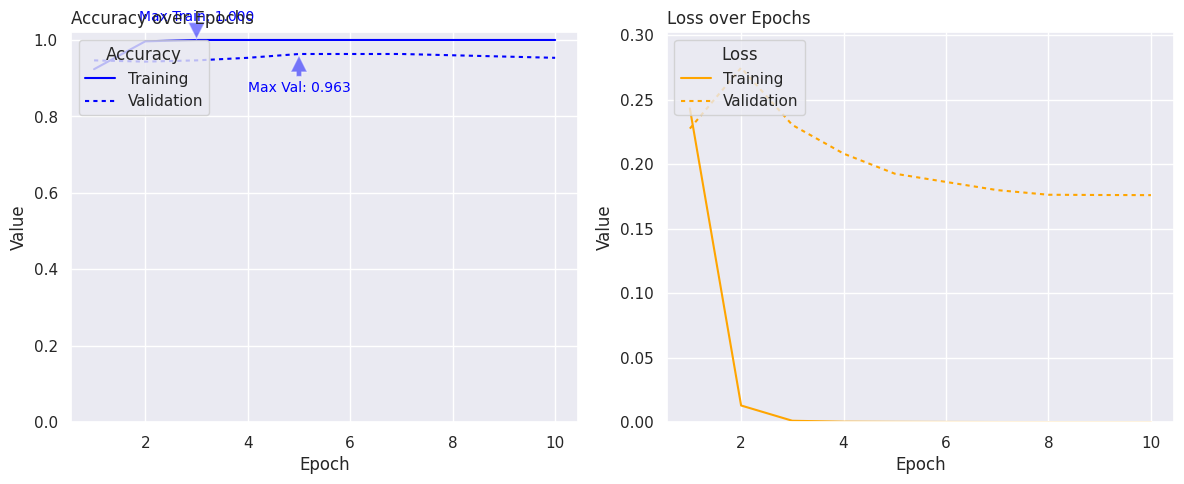

In [ ]:
plot_nn_epochs(nn_history=best_model_arr['model_history'])

## Performance on the Test Dataset
The InceptionV3-based model’s classification performance was further validated on the test dataset, achieving an accuracy of 0.967 and an F1 score of 0.970. These results surpass the validation set performance, indicating strong generalization to unseen data. The model demonstrates robust capability in distinguishing dog and cat images, significantly outperforming the simpler CNN models and the classic ML models described earlier.

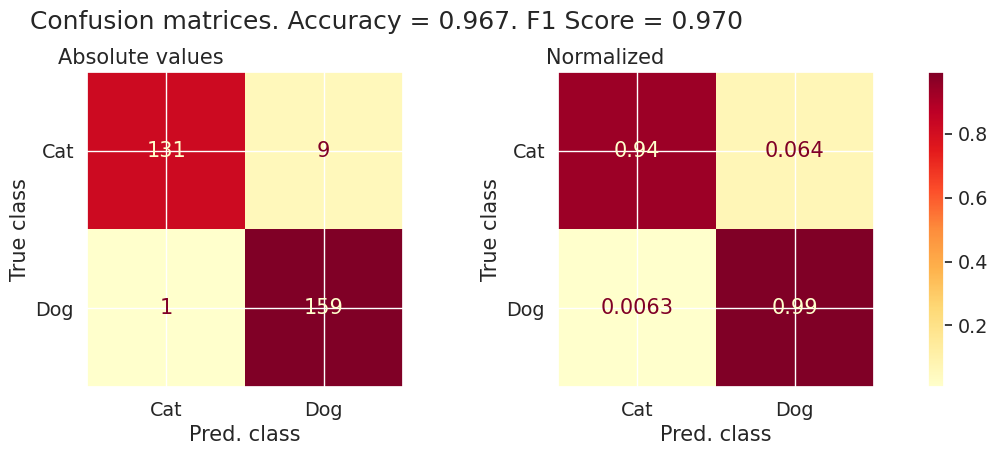

In [ ]:
cnn_inc_results = get_cnn_results(cnn_model=best_model, data_X=test_X, true_class=test_y)
# Labelling of the results
cnn_inc_results["Model"] = "Conv. Neural Net."; cnn_inc_results["Features"] = "TL: Inception"

The confusion matrix reveals that cat images are more prone to misclassification compared to dog images. Analysis of the misclassified images indicates that errors often occur in challenging cases, such as blurry images or those containing distracting objects. Some images are nearly impossible to classify correctly due to the animal being obscured by objects. Additionally, one image contains both a cat and a dog. This highlights a limitation of both the dataset's labels and the model’s design for mutually exclusive classes.

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


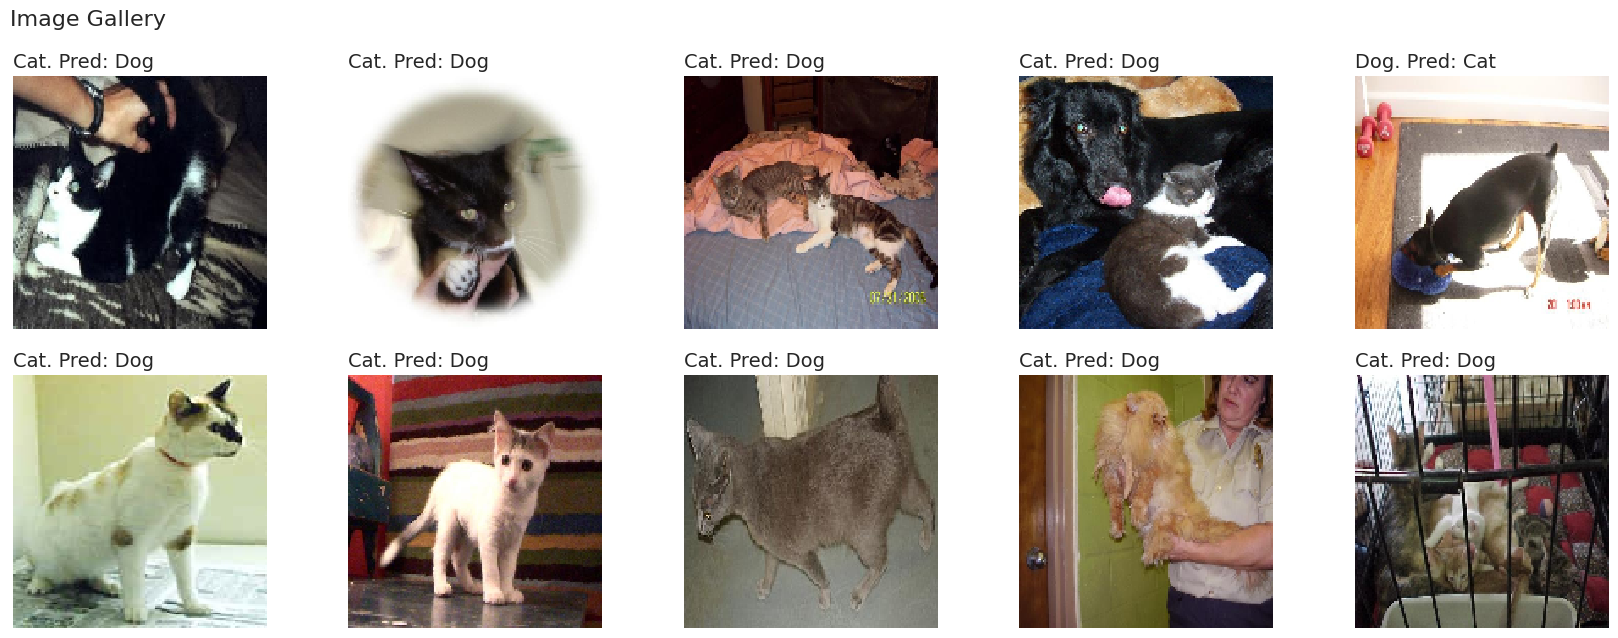

In [ ]:
# Predict the outcome. Get label instead of probability
pred_class_cnn_inc = best_model.predict(test_X).flatten()
pred_class_cnn_inc = (pred_class_cnn_inc>0.5).astype(int)

# See some examples of wrong predictions
wrong_predictions = (np.where(pred_class_cnn_inc!=test_y)[0]).tolist()
random_subset_wrong = np.random.choice(wrong_predictions, min(len(wrong_predictions), 15), replace=False)
plot_gallery(X_values = test_X, y_values = list(test_y),
             y_labels = pred_class_cnn_inc, selection = random_subset_wrong)

## Testing with custom cat or dog Images
To further evaluate the generalization capability of the InceptionV3-based model, this section provides functionality for users to classify a publicly accessible cat or dog image by providing its URL. The image is preprocessed using the same transformations applied in the data preparation pipeline, ensuring compatibility with the model’s input requirements. This interactive feature demonstrates the model’s ability to handle real-world images beyond the test dataset.

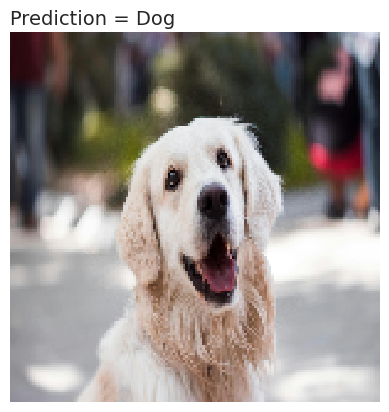

In [ ]:
IMAGE_URL = "https://images.pexels.com/photos/1490908/pexels-photo-1490908.jpeg"

# Load the image from the URL and preprocess it
new_X = image_from_url_preprocessing(IMAGE_URL)

# Use the trained model to predict the class of the image. Plot it
new_pred = best_model.predict(new_X, verbose = 0).flatten()
plot_single_image(X_values=new_X[0,:,:,:], subtitle_text="Prediction = " +
                  CLASS_NAMES[(new_pred>0.5).astype(int)[0]])

# Discussion and conclusion

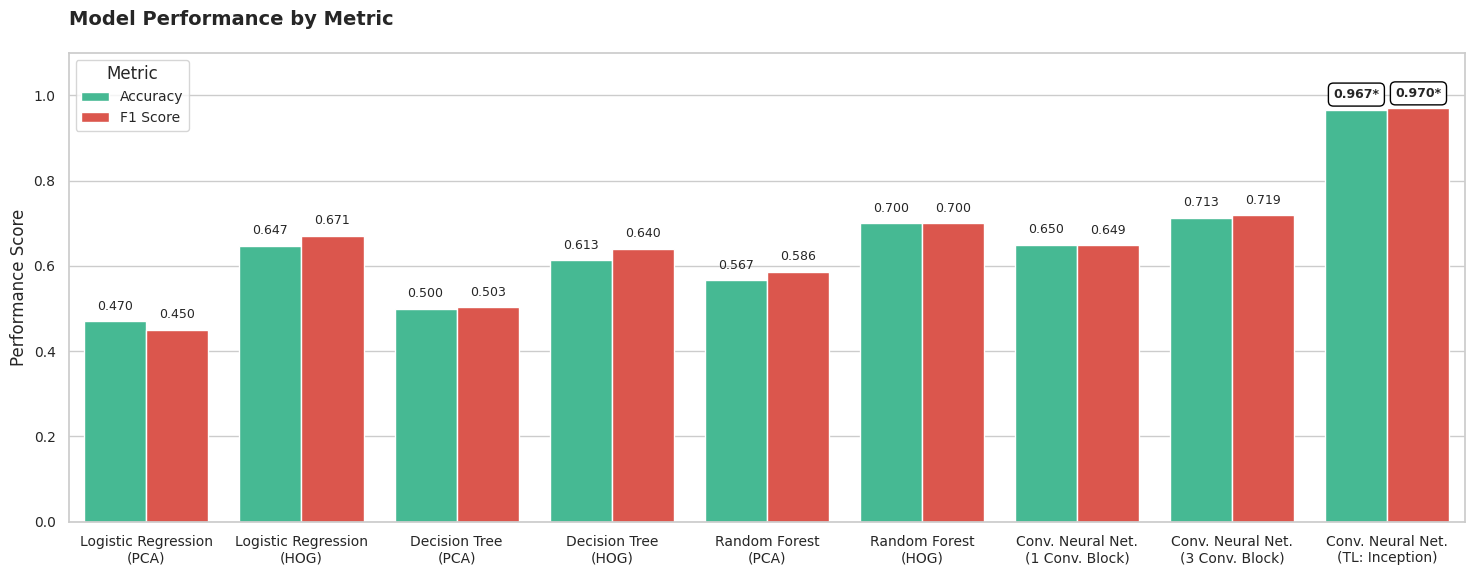

In [ ]:
# Load previous results, add the CNN results, and plot all of them
cnn_inc_results = pd.melt(cnn_inc_results, id_vars=["Model", "Features"], var_name="Metric",
                           value_vars=["Accuracy", "F1 Score"], value_name="Value")
ml_results = pd.concat([load_previous_results(), cnn_inc_results])
plot_ml_results(ml_results)

This study utilized transfer learning with the InceptionV3 model to classify 2,000 preprocessed cat and dog images (150x150 pixels, 3 color channels) from the Cats-vs-Dogs dataset, building on the CNN and classic machine learning experiments from the previous notebook. By fine-tuning the InceptionV3 model with custom output layers and leveraging pre-trained ImageNet weights, the approach achieved significantly higher performance than both custom CNNs (CNN-C1, CNN-C3) and traditional models (Logistic Regression, Decision Trees, Random Forest). The key findings, future work and applications are summarized below.

## Key Findings

1. **Superior Performance of Transfer Learning**: The InceptionV3-based model achieved a test accuracy of 0.967 and an F1 score of 0.970, far surpassing the custom CNNs (CNN-C1: 0.650 accuracy, 0.649 F1 score; CNN-C3: 0.713 accuracy, 0.719 F1 score) and the best classic ML model (Random Forest with HOG: 0.700 accuracy, 0.700 F1 score). This demonstrates the power of transfer learning in leveraging pre-trained features to handle high-dimensional image data effectively without manual feature engineering.
2. **Effective Fine-Tuning**: By fine-tuning only the last 15 layers of InceptionV3 with a dropout rate of 0.2 and a learning rate of 0.0001, the model converged rapidly, as shown in epoch-wise training plots, and achieved a validation accuracy of 0.963 and F1 score of 0.962. The slight improvement on the test set suggests robust generalization, addressing the overfitting issues observed in CNN-C1 and CNN-C3.
3. **Balanced Classification**: The confusion matrix indicated slightly higher misclassification rates for cat images, with errors often attributed to challenging inputs (e.g., blurry images, occlusions, or images containing both a cat and a dog). This highlights the model’s robustness for clear images but reveals limitations in handling ambiguous cases.
4. **Limited Dataset Size**: While transfer learning mitigated overfitting compared to CNN-C1 and CNN-C3, the dataset of 2,000 images may still constrain the model’s ability to generalize to highly diverse real-world images.
5. **Practical Applicability**: The interactive feature for classifying user-provided images via URLs demonstrated the model’s ability to generalize to real-world data, reinforcing its potential for applications like automated pet identification in veterinary or shelter settings.

## Future Work and Applications

To further enhance the model’s performance and address its limitations, the following strategies are proposed:

- **Expanded Hyperparameter Tuning**: Broaden the search to include `trainable_layers` (e.g., 10, 20, 30) and `dense_neurons` (e.g., 256, 512, 1024, 2048). A random grid search, sampling combinations from a grid of `learning_rate` = log-uniform(1e-5, 1e-2) and `dropout_rate` = [0.1, 0.2, 0.3, 0.4, 0.5], could efficiently identify optimal configurations.
- **Data Augmentation**: Implement techniques such as random rotations, horizontal flips, and brightness adjustments to improve robustness to occlusions, pose variations, and lighting changes, though care must be taken to ensure augmentations reflect real-world variability.
- **Larger and More Diverse Datasets**: Incorporate additional images from varied sources (e.g., different breeds, backgrounds) to enhance generalization, particularly for challenging cases.
- **Multi-Label Classification**: Transition to a multi-label framework to handle images containing both cats and dogs, enabling simultaneous class predictions.
- **Alternative Architectures**: Compare InceptionV3 with models like ResNet50 or EfficientNet to identify the best architecture for this task.
- **Interpretability**: Use Grad-CAM or saliency maps to visualize feature importance, providing insights into misclassification causes and improving model transparency.
- **Applications**: The model’s high accuracy and interactive classification feature support applications in mobile apps for pet identification, animal shelter management, or wildlife monitoring. Extending to multi-class or fine-grained classification (e.g., breed identification) could further expand its utility.

In conclusion, the InceptionV3-based model achieved a test accuracy of 0.967 and an F1 score of 0.970, significantly outperforming custom CNNs and classic ML models. Transfer learning effectively mitigated overfitting, leveraging pre-trained features to handle the high-dimensional Cats-vs-Dogs dataset. However, challenges with ambiguous inputs and dataset size highlight areas for improvement. Future work focusing on expanded hyperparameter tuning, data augmentation, and larger datasets will further enhance performance, paving the way for robust real-world image recognition applications.